In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [5]:
mu0 = 0
sigma0 = 1

In [6]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G])
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

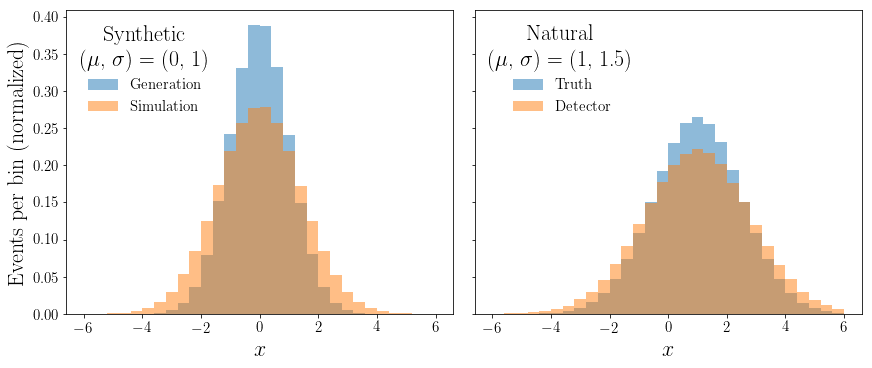

In [7]:
bins = np.linspace(-6, 6, 31)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [8]:
iterations = 5

In [9]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_G))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [10]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [11]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen., actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_pull


ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1500000 samples, validate on 500000 samples
Epoch 1/200





1500000/1500000 [==============================] - 9s 6us/step - loss: 0.6410 - acc: 0.6246 - val_loss: 0.6368 - val_acc: 0.6300
Epoch 2/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.6369 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6303
Epoch 3/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6368 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 4/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6367 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6305
Epoch 5/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6367 - acc: 0.6303 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 6/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6367 - acc: 0.6302 - val_loss:

Epoch 11/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5000 - val_loss: 0.6649 - val_acc: 0.4997
Epoch 12/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5000 - val_loss: 0.6650 - val_acc: 0.4998
Epoch 13/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5003 - val_loss: 0.6650 - val_acc: 0.4999
Epoch 14/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5000 - val_loss: 0.6649 - val_acc: 0.4997
Epoch 15/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5001 - val_loss: 0.6650 - val_acc: 0.4998
Epoch 16/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6650 - acc: 0.5001 - val_loss: 0.6649 - val_acc: 0.4997
Epoch 17/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.6650 - acc: 0.5000 - val_loss: 0.6650 - val_acc: 0.4997
Epoch

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.6175 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 2/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 3/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6098 - acc: 0.5002 - val_loss: 0.6096 - val_acc: 0.4997
Epoch 4/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 5/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 6/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6099 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4997
Epoch 7/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.6098 - acc: 0.50

1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6932 - acc: 0.5422 - val_loss: 0.6942 - val_acc: 0.5314
Epoch 44/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6932 - acc: 0.5373 - val_loss: 0.6943 - val_acc: 0.5527
Epoch 45/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6931 - acc: 0.5394 - val_loss: 0.6944 - val_acc: 0.5424
Epoch 46/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6932 - acc: 0.5386 - val_loss: 0.6944 - val_acc: 0.5328
Epoch 47/200
1500000/1500000 [==============================] - 10s 6us/step - loss: 0.6930 - acc: 0.5422 - val_loss: 0.6942 - val_acc: 0.5432
Epoch 48/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6932 - acc: 0.5383 - val_loss: 0.6943 - val_acc: 0.5510
Epoch 49/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.6931 - acc: 0.5426 - val_loss: 0.6942 - val_acc: 0.5380
Epoch 50/200
15000

Epoch 4/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5927 - acc: 0.5001 - val_loss: 0.5930 - val_acc: 0.4997
Epoch 5/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5927 - acc: 0.5001 - val_loss: 0.5930 - val_acc: 0.4997
Epoch 6/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5927 - acc: 0.5000 - val_loss: 0.5929 - val_acc: 0.4998
Epoch 7/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5928 - acc: 0.5001 - val_loss: 0.5929 - val_acc: 0.4997
Epoch 8/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5927 - acc: 0.5001 - val_loss: 0.5929 - val_acc: 0.4997
Epoch 9/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.5928 - acc: 0.5001 - val_loss: 0.5929 - val_acc: 0.4996
Epoch 10/200
1500000/1500000 [==============================] - 8s 5us/step - loss: 0.5928 - acc: 0.5001 - val_loss: 0.5929 - val_acc: 0.4998
Epoch 11/200

ITERATION 1:


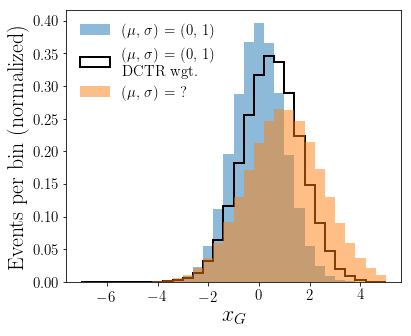

ITERATION 2:


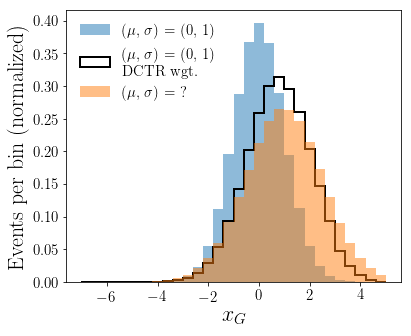

ITERATION 3:


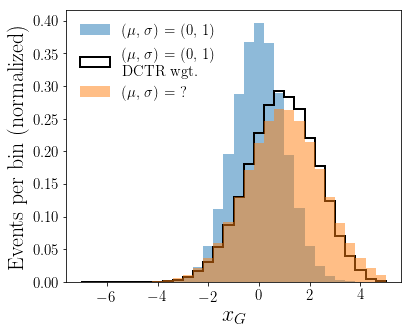

ITERATION 4:


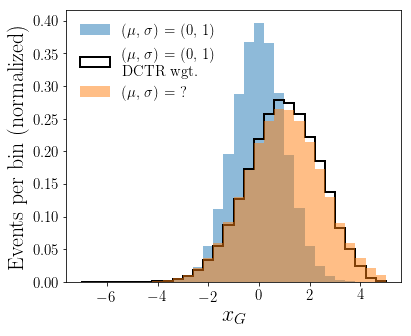

ITERATION 5:


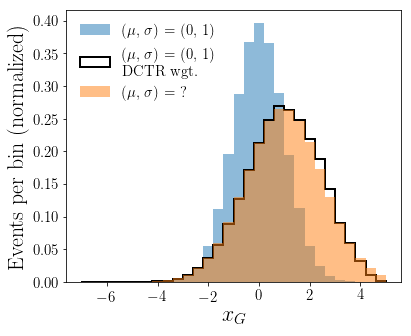

In [12]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    bins = np.linspace(-7, 5, 31)
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()